In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = df.drop(["customerID"], axis=1)
df = df.drop(labels=df[df["tenure"] == 0].index, axis=0)

df["TotalCharges"] = pd.to_numeric(df.TotalCharges, errors="coerce")
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

display(df.head(1))
display(df["Churn"].value_counts())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0


Churn
0    5163
1    1869
Name: count, dtype: int64

In [3]:
cat_col = df.select_dtypes("object").columns.tolist()
num_col = list(set(df.columns) - set(cat_col) - set(["Churn"]))
df[cat_col] = df[cat_col].astype("category")

X = df[num_col + cat_col]
y = df["Churn"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40, stratify=y)

d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_col, free_raw_data=False)
d_valid = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_col, free_raw_data=False)

In [4]:
# 0.835465
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "max_depth": 4,
    "metric": {"auc"},
    "num_leaves": 31,
}

gbm = lgb.train(
    params,
    d_train,
    num_boost_round=1,
    valid_sets=d_valid,
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),
    ],
)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265746 -> initscore=-1.016316
[LightGBM] [Info] Start training from score -1.016316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's auc: 0.845167


<Axes: >

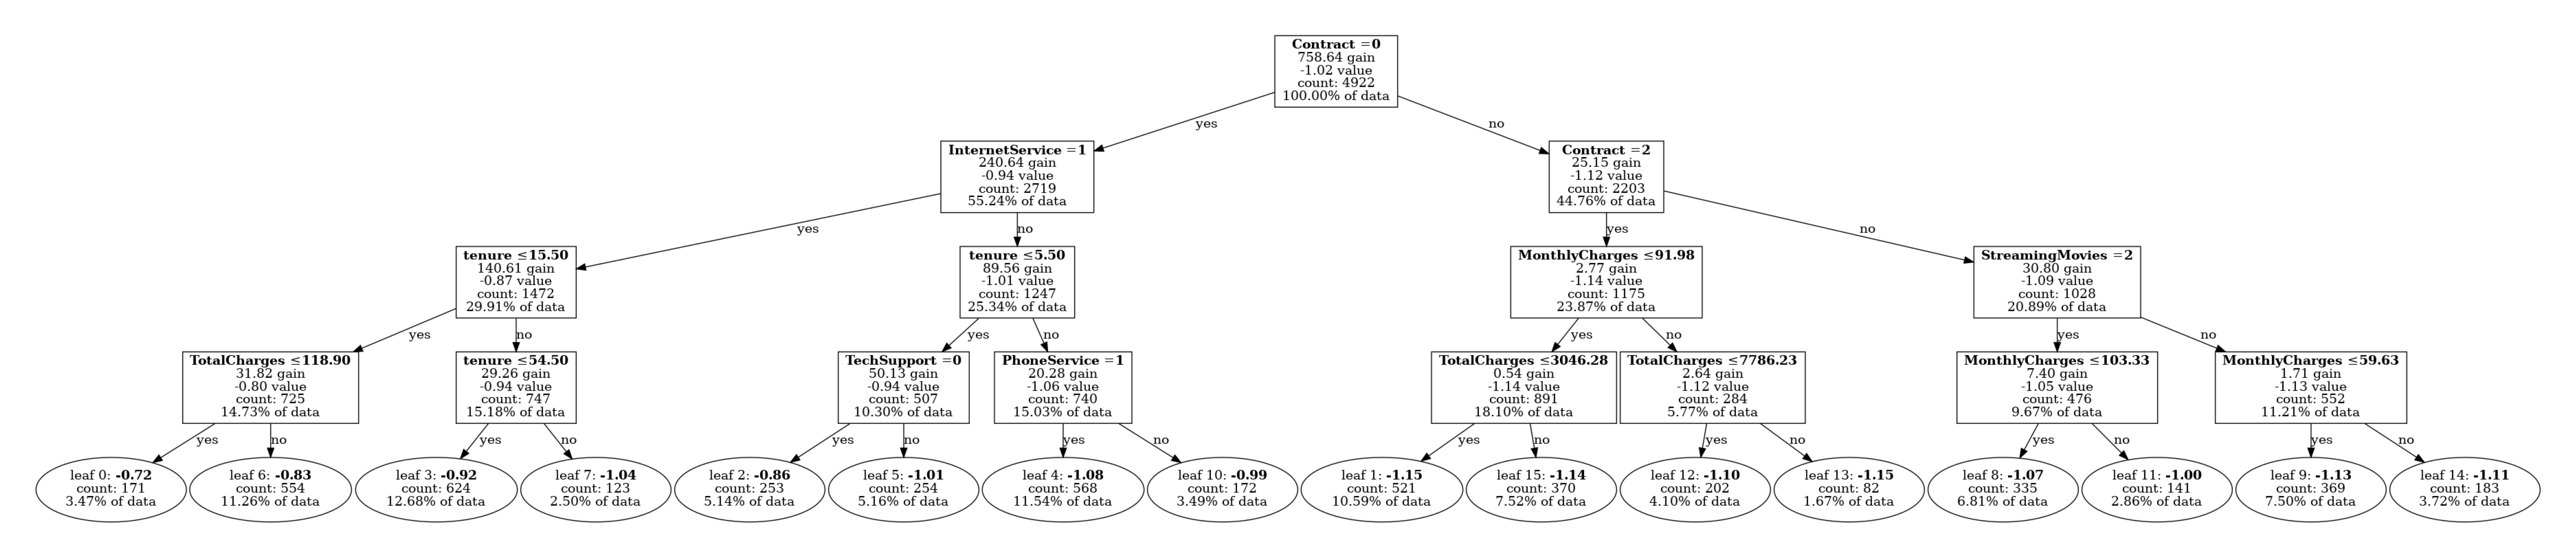

In [5]:
lgb.plot_tree(
    gbm,
    dpi=800,
    figsize=(10, 6),
    tree_index=0,
    show_info=[
        "split_gain",
        "internal_count",
        "internal_value",
        "leaf_count",
        "data_percentage",
    ],
    precision=2,
    orientation="vertical",
)

In [18]:
TotalCharges <= 118.90; tenure <= 15.50 InternetService = 1 Contract = 0

([['Female', 'Male'],
  ['No', 'Yes'],
  ['No', 'Yes'],
  ['No', 'Yes'],
  ['No', 'Yes'],
  ['No', 'No phone service', 'Yes'],
  ['DSL', 'Fiber optic', 'No'],
  ['No', 'No internet service', 'Yes'],
  ['No', 'No internet service', 'Yes'],
  ['No', 'No internet service', 'Yes'],
  ['No', 'No internet service', 'Yes'],
  ['No', 'No internet service', 'Yes'],
  ['No', 'No internet service', 'Yes'],
  ['Month-to-month', 'One year', 'Two year'],
  ['No', 'Yes'],
  ['Bank transfer (automatic)',
   'Credit card (automatic)',
   'Electronic check',
   'Mailed check']],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [12]:
import pickle
from CHAID import Tree

cols_dict = dict(zip(num_col, ["ordinal"] * len(num_col)))
cols_dict.update(dict(zip(cat_col, ["nominal"] * len(cat_col))))

tree = Tree.from_pandas_df(
    df.sample(1000),
    i_variables=cols_dict,
    d_variable="Churn",
    max_splits=5,
    max_depth=3,
    min_child_node_size=30,
)

with open("tree.pickle", "wb") as fout:
    pickle.dump(tree, fout, protocol=pickle.HIGHEST_PROTOCOL)

with open("tree.pickle", "rb") as fin:
    tree = pickle.load(fin)

print(tree.to_tree())

([], {np.int64(0): np.float64(733.0), np.int64(1): np.float64(267.0)}, (Contract, p=7.740453588911938e-38, score=170.9035464893412, groups=[['Month-to-month'], ['One year'], ['Two year']]), dof=2))
├── (['Month-to-month'], {np.int64(0): np.float64(290.0), np.int64(1): np.float64(228.0)}, (PaymentMethod, p=1.6659585203390025e-12, score=49.842501470599096, groups=[['Bank transfer (automatic)', 'Mailed check', 'Credit card (automatic)'], ['Electronic check']]), dof=1))
│   ├── (['Bank transfer (automatic)', 'Mailed check', 'Credit card (automatic)'], {np.int64(0): np.float64(186.0), np.int64(1): np.float64(75.0)}, (OnlineSecurity, p=0.00016336148232601018, score=14.211587112310891, groups=[['No'], ['No internet service', 'Yes']]), dof=1))
│   │   ├── (['No'], {np.int64(0): np.float64(94.0), np.int64(1): np.float64(57.0)}, <Invalid Chaid Split> - the max depth has been reached)
│   │   └── (['No internet service', 'Yes'], {np.int64(0): np.float64(92.0), np.int64(1): np.float64(18.0)}, <Inv

In [13]:
import plotly

tree.render(path=None, view=False)